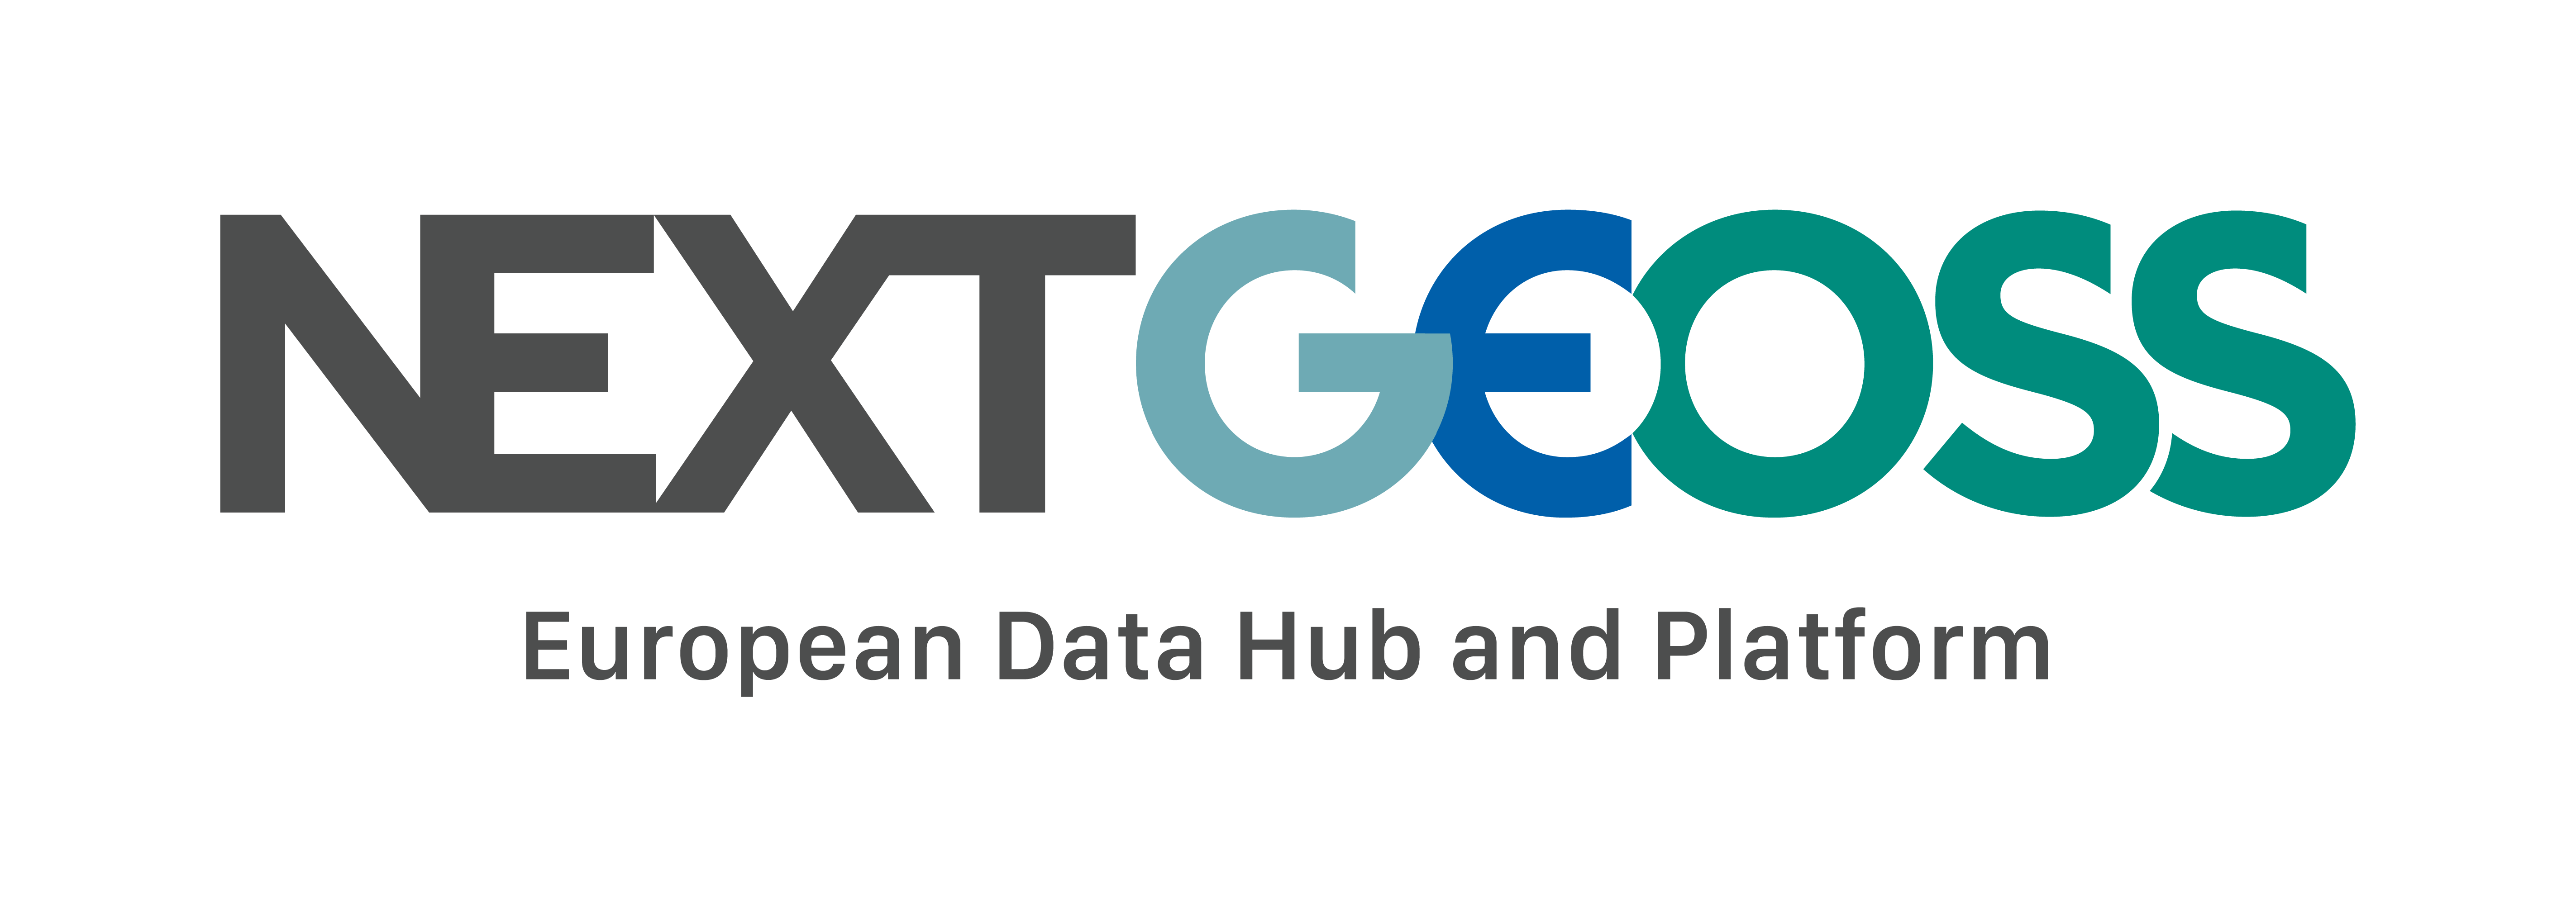

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

PATH = "./img/"
Image(filename = PATH + "NextGEOSS-Logo.png", width=512, height=256)

# Introduction to NextGEOSS Energy Pilot. (README First !)

## Access time series of gridded data from CAMS Radiation

### This pilot allows to requests for time-series of solar radiation over a regular grid of points covering area of interest (AOI).

#### GEOGRAPHICAL AREA

Geographical coverage of the CAMS radiation product is the field-of-view of the Meteosat satellite, roughly speaking Europe, Africa, Atlantic Ocean, Middle East (-66° to 66° in both latitudes and longitudes).

#### DATA

The data you request come from CAMS (Copernicus Atmosphere Monitoring Service) Radiation product from a two years time period including the following parameters (Atmosphere optical properties, Ground reflectance, Cloud optical properties, Atmosphere radiative transfer). **#IMPORTANT NOTE: ONLY THE YEARS 2005 AND 2006 ARE CURRENTLY AVAILABLE FOR THIS PILOT#**

#### HOW TO REQUEST THE DATA

The request to the data is made using an **OGC (Open Geospatial Consortium)** standard Web service called **WPS (Web Processing Service)**. This WPS is located remotely on a cloud server and provided as an asynchronous request to the CAMS Radiation process in order to deliver time series of gridded data on selected AOI.

The parameters are first encoded in an url and sent to the Cloud as a WPS request. 

This notebook will first demonstrate how to build the first url. It will then provide a set of command that fully automate the subsequent "treasure hunt" up to the downloading of the data.

#### HOW TO USE THE DATA

Once downloaded as an HDF5 encode file, the Notebook provides you with several results displays:
* An animated display of the various time frame layers
* A use case where a time-series of a single is point is compared to an average of gridded data over a given region (NUTS-3 shape)
* A use case where a time-series of a single is point is compared to an average of gridded data over a given geometrical AOI (Area Of Interest)

**Please allow some time for data to be processed and downloaded. When done you'll have a preview of your time series of gridded data at the bottom of the page. The following example retrieve a full day every 15 mn. from 00:15 providing you with 96 layers over an AOI covering France**


# Needed libraries: (Optional reading)

In the following code cells, you'll find various libraries that are needed in order to ensure the pilot to properly run the code and display the results. As a sum-up from a scratch installation you'll need to install the following libraries:
* conda install gdal
* conda install shapely 
* conda install fiona 
* conda install pyproj 
* conda install geopandas
* conda install numpy
* conda install cartopy
* conda install nodejs
* conda install ipywidgets
* conda install h5py
* conda install matplotlib
* conda install urllib3


In [2]:
import re, time

from urllib3.contrib.socks import SOCKSProxyManager
from urllib3 import PoolManager

import h5py
import matplotlib.pyplot as plt
%matplotlib inline

# Encoding the request in a url: (Optional reading)


The first url is the only wat you need to worry about, as it is where you define the particulars of your request (inputs, methods, outputs etc). 

**Url decomposition**
The url can be decomposed in 4 parts:
* The 'base string' defines the requested service:

In [3]:
base_str =  'http://gridded-data.armines.nextgeoss.terradue.com/wps/WebProcessingService?service=wps&version=1.0.0&request=Execute&identifier=com.terradue.wps_oozie.process.OozieAbstractAlgorithm&'

* The inputs string sets the parameters of the request:

In [4]:
input_str = 'dataInputs=bbox=-5.0,46.0,6.0,45.0;width=300;height=300;datex=2453385.510416666666;dt=0.010441666666;count=96;min_tile_width=100;min_tile_height=100;&'

* The output string:

In [5]:
output_str = 'ResponseDocument=result_distribution@mimeType=application/xml;result_osd@mimeType=application/xml&storeExecuteResponse=true&status=true'

The final url is the aggregation of the 4 parts:

In [6]:
url_request = base_str+input_str+output_str
print(url_request)

http://gridded-data.armines.nextgeoss.terradue.com/wps/WebProcessingService?service=wps&version=1.0.0&request=Execute&identifier=com.terradue.wps_oozie.process.OozieAbstractAlgorithm&dataInputs=bbox=-5.0,46.0,6.0,45.0;width=300;height=300;datex=2453385.510416666666;dt=0.010441666666;count=96;min_tile_width=100;min_tile_height=100;&ResponseDocument=result_distribution@mimeType=application/xml;result_osd@mimeType=application/xml&storeExecuteResponse=true&status=true


# Change the input parameters here: !!! (README)


While it is possible to manually modify the url, simple python functions can make WPS more flexible. 
The input parameters can be specified by changing the value in <font color='green'>green</font>. In the default example we've selected an AOI (Area Of Interest) covering France with a 300x300 resolution for one day (Saturday 2005 Jan) starting at 00:15h every 15 minutes resulting in HDF file of 96 layers This includes:
* **lon_min** (Left side of a bounding box longitude wise in degree - default is -5.5)
* **lat_max** (Right side of a bounding box latitude wise in degree - default is 51.3)
* **lon_max** (Right side of a bounding box longiture wise in degree - default is 8.5)
* **lat_min** (Left side of a bounding box latitude wise in degree - default is 41.0)
* **width** (Size in pixel of the width of the result map - default is 300)
* **height** (Size in pixel of the height of the result map - default is 300)
* **count** (Number of occurence in the time serie of gridded data - default is 96 (Covers 1 day every 15 mn))
* **datex** (Begin date in Julian date - default is Saturday 2005 Jan 15	00:15)
* **dt** (Time span for the number of occurence in Julian time - default is 15 mn)

In [7]:
lon_min=-5.5
lat_max=51.3
lon_max=8.5
lat_min=41.0
width=300
height=300
count=96
datex=2453385.510416666666
dt=0.010441666666

In [8]:
input_str = 'dataInputs=bbox={lon_min:.1f},{lat_max:.1f},{lon_max:.1f},{lat_min:.1f};width={width:d};height={height:d};datex={datex:.12f};dt={dt:.12f};count={count:d};min_tile_width=100;min_tile_height=100;&'
input_str = input_str.format(lon_min=lon_min,lat_max=lat_max,lon_max=lon_max,lat_min=lat_min,width=width,height=height,count=count,datex=datex,dt=dt)
print(input_str)

dataInputs=bbox=-5.5,51.3,8.5,41.0;width=300;height=300;datex=2453385.510416666511;dt=0.010441666666;count=96;min_tile_width=100;min_tile_height=100;&


In [9]:
url_request = base_str+input_str+output_str
print(url_request)

http://gridded-data.armines.nextgeoss.terradue.com/wps/WebProcessingService?service=wps&version=1.0.0&request=Execute&identifier=com.terradue.wps_oozie.process.OozieAbstractAlgorithm&dataInputs=bbox=-5.5,51.3,8.5,41.0;width=300;height=300;datex=2453385.510416666511;dt=0.010441666666;count=96;min_tile_width=100;min_tile_height=100;&ResponseDocument=result_distribution@mimeType=application/xml;result_osd@mimeType=application/xml&storeExecuteResponse=true&status=true


#  Parsing the query and request access to the data: (Optional reading)

Several steps are necessary to download the data. While they may seem somewhat cumbersome, once you have encoded your request in url_request you can simply run the following code.

## Get 1st file and extract info
### Warning: this line launches a request. It should not be called several time !

In [10]:
# Warning: this line launches a request. It should not be called several time
r = PoolManager().request('GET', url_request)

In [11]:
xml = r.data.decode('utf-8')
for line in xml.split('\n'):
        if re.search('statusLocation="http.*?"',line):
            my_url_1 = re.sub('.*\n.*statusLocation="(.*?)".*','\\1',xml)

In [12]:
my_url_1

'http://gridded-data.armines.nextgeoss.terradue.com/wps/RetrieveResultServlet?id=48e0bac7-ec7e-4be4-99d7-d7349844ef86'

## Get 2nd file and extract info

In [13]:
my_match = None
my_url_2 = ''
while not my_match:
    r = PoolManager().request('GET', my_url_1)
    xml = r.data.decode('utf-8')
    for line in xml.split('\n'):
        if re.search('Reference href="http.*?results.metalink"',line):
            my_url_2 = re.sub('.*Reference href="(.*?results.metalink)".*','\\1',xml)
            my_match = True
            break
    if not my_match:
        time.sleep(10)

In [14]:
my_url_2

'http://gridded-data.armines.nextgeoss.terradue.com/data/run/mccloud_map_wps/0000043-181001000009300-oozie-oozi-W/results.metalink'

## Get 3rd file and extract info

In [15]:
final_url = ''
r = PoolManager().request('GET', my_url_2)
xml = r.data.decode('utf-8')
final_url = ''
for line in xml.split('\n'):
    if re.search('<url>(http.*?)</url>',line):
        final_url = re.sub('.*.*<url>(http.*?)</url>.*','\\1',line)
        break


In [16]:
final_url

'http://gridded-data.armines.nextgeoss.terradue.com/data/run/mccloud_map_wps/0000043-181001000009300-oozie-oozi-W/_results/result.h5'

## Download final data:

In [17]:
r = PoolManager().request('GET', final_url)

with open("my_data.h5", "wb") as f:
    content = r.data
    f.write(content)

In [18]:
my_data = h5py.File('my_data.h5', 'r')



# Animation of the time serie of gridded data (README)

### Code and libraries needed to display the data (Optional reading)

In [19]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature, COLORS
from IPython.display import display
import numpy as np
import ipywidgets as widgets 


In [20]:
# Define cartopy features:
resolution = "50m"
BORDERS = NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land',
                              resolution, edgecolor='black', facecolor='none')
STATES = NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes',
                             resolution, edgecolor='black', facecolor='none')
COASTLINE = NaturalEarthFeature('physical', 'coastline', resolution,
                                edgecolor='black', facecolor='none')
LAKES = NaturalEarthFeature('physical', 'lakes', resolution,
                            edgecolor='face',
                            facecolor=COLORS['water'])
LAND = NaturalEarthFeature('physical', 'land', resolution,
                           edgecolor='face',
                           facecolor=COLORS['land'], zorder=-1)
OCEAN = NaturalEarthFeature('physical', 'ocean', resolution,
                            edgecolor='face',
                            facecolor=COLORS['water'], zorder=-1)
RIVERS = NaturalEarthFeature('physical', 'rivers_lake_centerlines', resolution,
                             edgecolor=COLORS['water'],
                             facecolor='none')

In [21]:
def plot(varname='', time=0):
    # Import variable from data file:
    variable = np.array(my_data[varname][:])
    
    # Prepare figure
    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    ax.set_extent([lon_min, lon_max, lat_min, lat_max]) # ToDo: automate coordinates
    ax.set_title(varname, size=16)
    
    # Add country boundaries to plot
    ax.add_feature(BORDERS)
    ax.add_feature(LAKES)
    ax.add_feature(LAND)
    ax.add_feature(OCEAN)
    ax.add_feature(RIVERS)
    ax.add_feature(COASTLINE)

    # Contour based on variable chosen
    c = ax.imshow(variable[time], origin='lower', transform=ccrs.PlateCarree(), extent=[lon_min, lon_max, lat_min, lat_max])
    cb = fig.colorbar(c, ax=ax, shrink=0.7)
    
    cb.set_label(r'$W/m^{2}$', size='large')


In [22]:
# Display results:

var_widget = widgets.Dropdown(
    options={'G': 'G',
             'B': 'B',
             'Gc': 'Gc',
             'Bc': 'Bc'},
    description='Variable', alignment='center')

time_widget = widgets.SelectionSlider(description='Time', options=list(range(96)), width='40%')

play = widgets.Play(
    #interval=10,
    value=0,
    min=0,
    max=count-1,
    step=1,
    description="Press play",
    disabled=False
)

widgets.link((play, 'value'), (time_widget, 'value'))
mybox = widgets.Box([play, time_widget])

x = widgets.interactive(plot, varname=var_widget, time=play)



### Quickview of the variability in space and in time of the solar resource within the selected period (REAME)

**Click on the > play button below to run the animation.**

In [23]:

display(x.children[0],x.children[2],mybox)

Dropdown(description='Variable', options={'G': 'G', 'B': 'B', 'Gc': 'Gc', 'Bc': 'Bc'}, value='G')

Output()

Box(children=(Play(value=0, description='Press play', max=95), SelectionSlider(description='Time', options=(0,…

# Exploit the information to support decision making (README)

**In this section we aim at illustrating the value added of gridded data time-series of solar irradiation vs single point time-series of solar irradiation.**
#### Comparison with NUTS-3-region-wise average and geometrical AOI (Areal Of Interest)
* Demonstrate with this example the lack of representativeness of point-wise solar resource assessment for an extended region such as the NUT 3 region and for geometrical AOI.

**Gridded solar ressource assessment is required to provide representative spatially aggregated profiles !!!**

### Code and libraries needed to display the data (Optional reading)

In [24]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import Polygon

In [25]:
# To do so, we need the lat/lon of each pixel. 
# Since we are using a lat/lon projection, the lat/lon coordintates are regularly spaced:
my_lat = np.linspace(lat_min,lat_max,height).reshape(height,1)
my_lon = np.linspace(lon_min,lon_max,width).reshape(1,width)

my_lat = np.concatenate([my_lat]*width,axis=1)
my_lon = np.concatenate([my_lon]*height,axis=0)


In [26]:
# We then build a geodataframe containing location information for each pixel on the image:
my_gpd = gpd.GeoDataFrame()
my_gpd['Coordinates'] = list(zip(my_lon.flatten(), my_lat.flatten()))
my_gpd['geometry'] = my_gpd['Coordinates'].apply(Point)
my_gpd.crs = {'init' :'epsg:4326'}
my_gpd.head()


,Coordinates,geometry
0,"(-5.5, 41.0)",POINT (-5.5 41)
1,"(-5.453177257525083, 41.0)",POINT (-5.453177257525083 41)
2,"(-5.406354515050167, 41.0)",POINT (-5.406354515050167 41)
3,"(-5.3595317725752505, 41.0)",POINT (-5.35953177257525 41)
4,"(-5.312709030100335, 41.0)",POINT (-5.312709030100335 41)


In [27]:
# A (regular, pandas) DataFrame is then build. 
# Each column corresponds to one of the pixel referenced in the GeoDataFrame defined previously.
# The column name correponds to the pixel's coordinates.
my_tsdf = pd.DataFrame(my_data['G'][:].reshape(count,width*height),index=range(count))
my_tsdf.columns=my_gpd.Coordinates
my_tsdf = my_tsdf.fillna(0)

In [28]:
# Example:
my_tsdf.loc[40:45].head()

Coordinates,"(-5.5, 41.0)","(-5.453177257525083, 41.0)","(-5.406354515050167, 41.0)","(-5.3595317725752505, 41.0)","(-5.312709030100335, 41.0)","(-5.265886287625418, 41.0)","(-5.219063545150502, 41.0)","(-5.172240802675585, 41.0)","(-5.125418060200669, 41.0)","(-5.078595317725752, 41.0)",...,"(8.078595317725751, 51.3)","(8.125418060200667, 51.3)","(8.172240802675585, 51.3)","(8.219063545150501, 51.3)","(8.265886287625417, 51.3)","(8.312709030100333, 51.3)","(8.35953177257525, 51.3)","(8.406354515050166, 51.3)","(8.453177257525082, 51.3)","(8.5, 51.3)"
40,104.023918,120.430878,98.302910,89.023544,143.394958,126.573769,150.826416,111.197548,124.433487,128.191360,...,428.683563,408.044250,372.897003,395.081970,431.602783,431.070923,431.502686,431.974182,431.460663,427.801727
41,147.361298,134.733780,131.399429,135.329330,101.954857,101.626854,168.976959,120.547890,167.662094,169.490463,...,427.917603,426.240387,402.320679,437.704407,449.374390,448.781464,449.189392,449.638367,450.086975,450.535156
42,164.165710,113.024719,176.675095,149.061523,153.184738,162.270432,170.869263,142.252701,121.510735,120.251923,...,456.314362,457.487579,454.153595,461.718018,463.607666,462.959595,463.341858,463.766174,464.190125,464.613678
43,160.929794,188.552277,185.479782,198.487549,151.617996,168.787674,189.671112,163.480957,162.581924,159.990479,...,471.497803,471.893524,472.288940,472.683990,474.214630,473.517761,473.872772,474.270599,474.668060,475.065155
44,193.149155,188.295807,204.048050,213.310196,212.448868,155.842789,216.207718,117.718117,158.961609,216.147751,...,478.513092,478.880554,479.247742,479.614624,481.131561,480.392517,0.000000,0.000000,481.458221,481.827332


In [29]:
# The following function allows the retrieval of a single time stamp over the whole area
my_geom = my_gpd.geometry
def get_frame_df(t):
    plot_gpd = gpd.GeoDataFrame(my_tsdf.loc[t].transpose())
    plot_gpd.columns = ['G']
    plot_gpd = plot_gpd.reset_index()
    plot_gpd['geometry'] = my_geom
    return(plot_gpd)


In [30]:
import os
os.getcwd()

'/Users/lionelmenard/Documents/Work/Jupyter/armines-cams-gridded-data'

In [31]:
# Geopanads allows us to combine data from several sources. For example we may want to incorporate France adminstrative border into the plot:
laFrance = gpd.read_file('GeoData/DEPARTEMENT_METROPOLE.geojson')
laFrance = laFrance.to_crs({'init' :'epsg:4326'})
laFrance.head()

,ID_GEOFLA,CODE_DEPT,NOM_DEPT,CODE_CHF,NOM_CHF,X_CHF_LIEU,Y_CHF_LIEU,X_CENTROID,Y_CENTROID,CODE_REG,NOM_REG,geometry
0,DEPARTEM0000000000000001,39,JURA,300,LONS-LE-SAUNIER,895198,6622537,886172,6641548,27,BOURGOGNE-FRANCHE-COMTE,(POLYGON ((5.444410590616399 46.84534115162455...
1,DEPARTEM0000000000000002,42,LOIRE,218,SAINT-ETIENNE,808646,6482549,795655,6521581,84,AUVERGNE-RHONE-ALPES,"(POLYGON ((3.831740353926586 45.9994428066684,..."
2,DEPARTEM0000000000000003,76,SEINE-MARITIME,540,ROUEN,562355,6928721,550942,6952842,28,NORMANDIE,(POLYGON ((0.3871470776027273 49.7718770351546...
3,DEPARTEM0000000000000004,89,YONNE,024,AUXERRE,742447,6744261,748211,6750855,27,BOURGOGNE-FRANCHE-COMTE,(POLYGON ((3.126677387392826 47.99126841691494...
4,DEPARTEM0000000000000005,68,HAUT-RHIN,066,COLMAR,1024125,6784581,1016174,6763894,44,ALSACE-CHAMPAGNE-ARDENNE-LORRAINE,"(POLYGON ((6.9238240349725 47.95247126466695, ..."


In [32]:
# Define geometrical AOI:
p1 = Polygon([(3.7,43.4),(4,43.4),(4,43.8),(3.7,43.8)])
myPol = gpd.GeoSeries(p1)
myPol.crs = {'init' :'epsg:4326'}

# Resource for geometrical AOI:
my_intersection = my_gpd.within(myPol.geometry.iloc[0])
zone_ts = my_tsdf.loc[:,my_gpd[my_intersection].Coordinates].mean(axis=1)
my_tsdf.loc[:,my_gpd[my_intersection].Coordinates].mean(axis=1).iloc[45:55]

# Resource for its center:
distance = my_gpd.geometry.apply(lambda x: myPol.distance(x))
nearest_pt = my_gpd.iloc[distance.idxmin()]
center_ts_u2 = my_tsdf[nearest_pt.Coordinates.iloc[0]]


In [33]:
# Extract the shape of Herault from file:
my_dpt = laFrance[laFrance.NOM_DEPT=='HERAULT']

# Resource for Herault:
my_intersection = my_gpd.within(my_dpt.geometry.iloc[0])
herault_ts = my_tsdf.loc[:,my_gpd[my_intersection].Coordinates].mean(axis=1)

# Resource for its center:
distance = my_gpd.geometry.apply(lambda x: my_dpt.centroid.distance(x))
nearest_pt = my_gpd.iloc[distance.idxmin()]
center_ts_u1 = my_tsdf[nearest_pt.Coordinates.iloc[0]]



### Use case 1: NUTS-3 Region-wise average vs point-wise solar irradiation resource assessment (REAME)

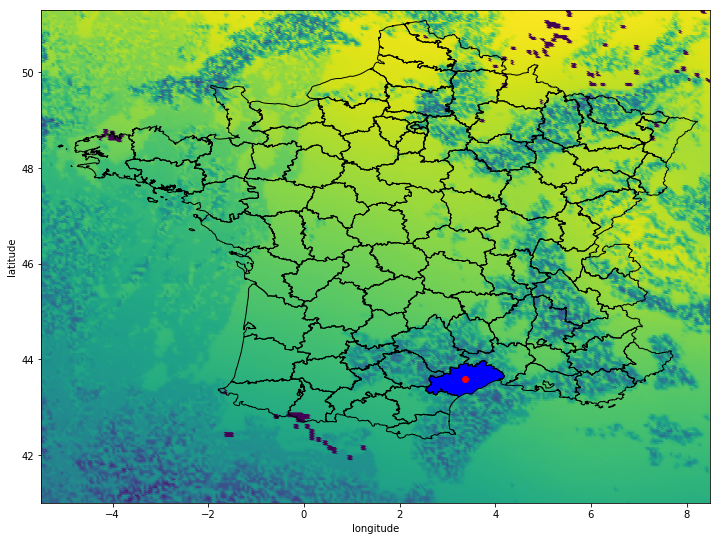

In [34]:

# Plot shape on top of our data:
## We use our data as base for our plot:
frame_to_plot = get_frame_df(45)
base = frame_to_plot.plot( column='G',figsize=(12,12))
base.set_xlabel("longitude")
base.set_ylabel("latitude")

## Add French borders to the plot:
laFrance.boundary.plot(ax=base,color='black',lw=1)
base.set_ylim(lat_min, lat_max)
base.set_xlim(lon_min, lon_max)

## Plot department and its center
my_dpt.plot(ax=base,color='blue',lw=2)
my_dpt.centroid.plot(ax=base,color='red')

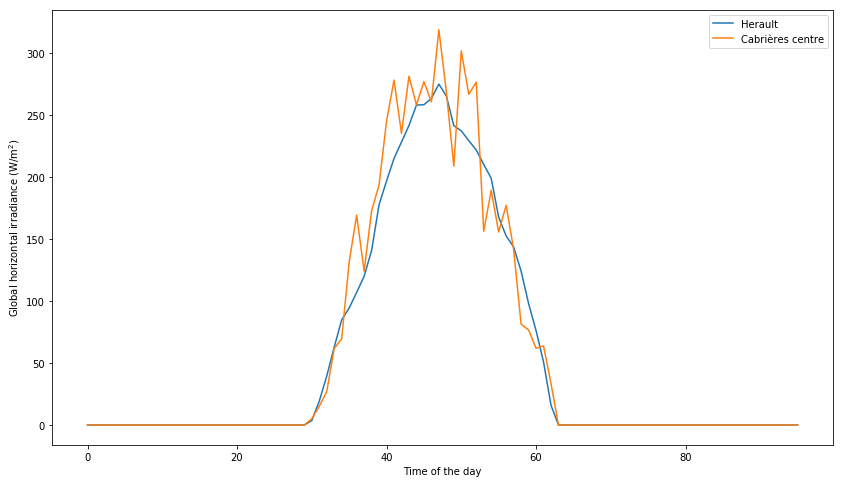

In [35]:
plt.figure(figsize=(14,8))
plt.plot(herault_ts,label='Herault')
plt.plot(center_ts_u1,label='Cabrières centre')
plt.xlabel('Time of the day')
plt.ylabel('Global horizontal irradiance (W/m$^2$)')
plt.legend()

### Use case 2: Geometrical AOI (Area Of Interest) vs point-wise solar irradiation resource assessment (REAME)

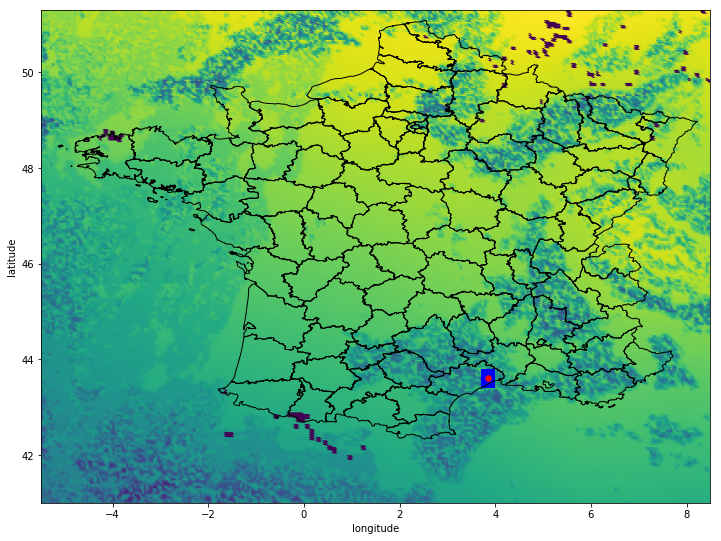

In [36]:
# Plot shape on top of our data:
## We use our data as base for our plot:
frame_to_plot = get_frame_df(45)
base = frame_to_plot.plot( column='G',figsize=(12,12))
base.set_xlabel("longitude")
base.set_ylabel("latitude")

## Add French borders to the plot:
laFrance.boundary.plot(ax=base,color='black',lw=1)
base.set_ylim(lat_min, lat_max)
base.set_xlim(lon_min, lon_max)

## Plot our polygon and its center
myPol.plot(ax=base,color='blue')
myPol.centroid.plot(ax=base,color='red',lw=.5)

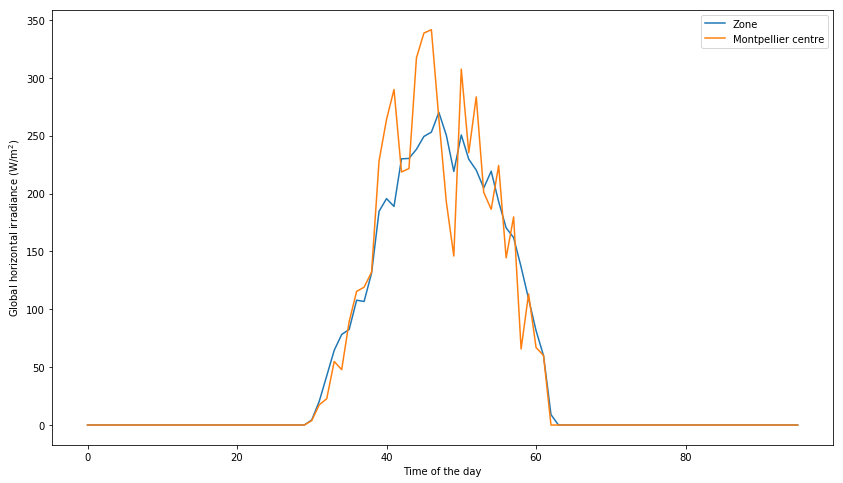

In [37]:
# Compare resources
plt.figure(figsize=(14,8))
plt.plot(zone_ts,label='Zone')
plt.plot(center_ts_u2,label='Montpellier centre')
plt.xlabel('Time of the day')
plt.ylabel('Global horizontal irradiance (W/m$^2$)')
plt.legend()
